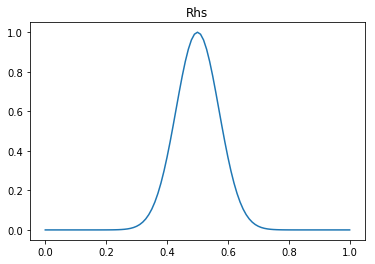

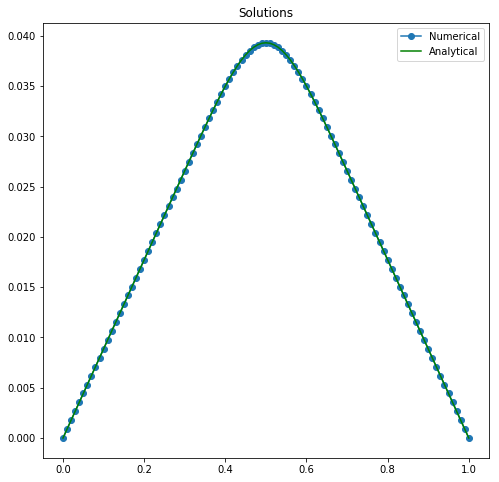

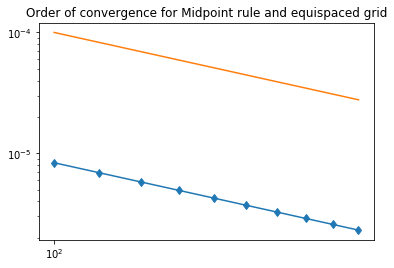

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate
from scipy.special import erf
from math import pi


def rhs1(x):
    return np.sin(pi*x)

def rhs2(x):
    return np.exp(-1e4*(x-0.5)**2)
    
def rhs3(x):
    return np.cos(2*pi*x)

def rhs4(x):
    return np.exp(-100*np.abs(x-0.5)**2)

    
def uex(x,rhs):
    if (rhs == rhs1):
        return np.sin(pi*x)/(pi**2)
    elif rhs == rhs2:
        return 1/20000*(100*np.sqrt(pi)*x*erf(50-100*x)+50*np.sqrt(pi)*erf(50*(2*x-1)) + 50*np.sqrt(pi)*erf(50) - 1/np.exp(2500*(1-2*x)**2) + 1/np.exp(2500))
    elif rhs == rhs3:
        return -(np.sin(pi*x)**2)/(2*pi**2)
    elif rhs == rhs4:
        return 1/200*(5*np.sqrt(pi)*(2*x-1)*erf(5-10*x) + 5*np.sqrt(pi)*erf(5)-1/np.exp(25*(1-2*x)**2) + 1/np.exp(25))
    
def convergence_plot_equispaced(mrange,quadrature,rhs):
    err = []
    for M in mrange:
        x = np.linspace(0,1,M+1)
        h = 1/M
        b = load_vector(M,rhs,x,quadrature)
        A = -np.diag(np.ones(M-2),-1) + 2*np.diag(np.ones(M-1)) - np.diag(np.ones(M-2),+1)
        A = A/h**2 #stiffness matrix
        u_int = np.linalg.solve(A,b)
        err.append(np.linalg.norm(u_int-uex(x[1:-1],rhs),np.Inf) )
    plt.figure()
    plt.loglog(mrange,err,'-d',mrange,1/mrange**2)
    plt.title('Order of convergence for ' +str(quadrature) +str(' rule and ') +str('equispaced grid'))
    plt.show()


def load_vector(M,rhs,x,quadrature):
    h = 1/M
    b = []
    if quadrature == 'Gaussian':
        for i in range(1,M):
            b.append(integrate.quad(lambda y: (1/h**2)*(y-x[i-1])*rhs(y),x[i-1],x[i])[0] + integrate.quad(lambda y: (1/h**2)*(x[i+1]-y)*rhs(y),x[i],x[i+1])[0])
    elif quadrature == 'Midpoint':
        b=rhs(x[1:-1])
    return b

#### Choose rhs
rhs = rhs4
####

M = 100
h = 1/M
x = np.linspace(0,1,M+1)
A = -np.diag(np.ones(M-2),-1) + 2*np.diag(np.ones(M-1)) - np.diag(np.ones(M-2),+1)
A = A/h**2 #stiffness matrix
quad = 'Midpoint' #Gaussian or Midpoint
b = load_vector(M,rhs,x,quad)
#print(b)
u_int = np.linalg.solve(A,b)
U = np.zeros(M+1)
U[0] = 0
U[M] = 0
U[1:M] = u_int

plt.figure()
plt.plot(x,rhs(x),'-')
plt.title('Rhs')
plt.show()

plt.figure(figsize=(8,8))
plt.plot(x,U,'-o',label='Numerical')
plt.plot(x,uex(x,rhs),'g',label = 'Analytical')
plt.title('Solutions')
plt.legend()

mrange = np.arange(100,200,10)
convergence_plot_equispaced(mrange,quad,rhs)


In [9]:
print(u_int - uex(x[1:-1],rhs))

[1.75423912e-16 6.54641272e-16 1.89648644e-15 5.03069808e-15
 1.27172578e-14 3.12232878e-14 7.48637263e-14 1.75652895e-13
 4.03704847e-13 9.09152961e-13 2.00655638e-12 4.34049498e-12
 9.20265426e-12 1.91240253e-11 3.89529693e-11 7.77674973e-11
 1.52178209e-10 2.91879684e-10 5.48722075e-10 1.01110947e-09
 1.82616962e-09 3.23281768e-09 5.60942637e-09 9.54009735e-09
 1.59031899e-08 2.59844028e-08 4.16138846e-08 6.53221958e-08
 1.00503286e-07 1.51564222e-07 2.24031994e-07 3.24578905e-07
 4.60921971e-07 6.41551287e-07 8.75250125e-07 1.17038782e-06
 1.53399591e-06 1.97067673e-06 2.48143746e-06 3.06258414e-06
 3.70484002e-06 4.39286253e-06 5.10531423e-06 5.81559356e-06
 6.49325280e-06 7.10603373e-06 7.62235024e-06 8.01396082e-06
 8.25851961e-06 8.34168658e-06 8.25851961e-06 8.01396082e-06
 7.62235024e-06 7.10603373e-06 6.49325280e-06 5.81559356e-06
 5.10531423e-06 4.39286253e-06 3.70484002e-06 3.06258414e-06
 2.48143746e-06 1.97067673e-06 1.53399591e-06 1.17038782e-06
 8.75250126e-07 6.415512

Non-equidistant points

[0.000e+00 4.000e-04 1.600e-03 3.600e-03 6.400e-03 1.000e-02 1.440e-02
 1.960e-02 2.560e-02 3.240e-02 4.000e-02 4.840e-02 5.760e-02 6.760e-02
 7.840e-02 9.000e-02 1.024e-01 1.156e-01 1.296e-01 1.444e-01 1.600e-01
 1.764e-01 1.936e-01 2.116e-01 2.304e-01 2.500e-01 2.704e-01 2.916e-01
 3.136e-01 3.364e-01 3.600e-01 3.844e-01 4.096e-01 4.356e-01 4.624e-01
 4.900e-01 5.184e-01 5.476e-01 5.776e-01 6.084e-01 6.400e-01 6.724e-01
 7.056e-01 7.396e-01 7.744e-01 8.100e-01 8.464e-01 8.836e-01 9.216e-01
 9.604e-01 1.000e+00] (51,)


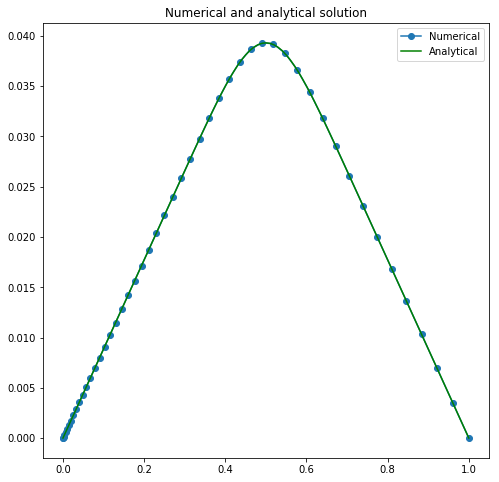

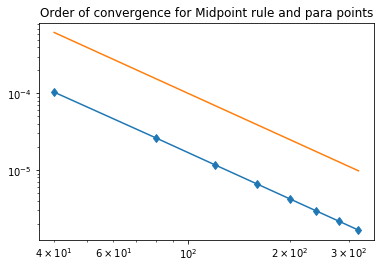

In [10]:
def nodegen(M,nodtype):
    if nodtype == 'para':
        x = np.zeros(M+1)
        for i in range(0,M+1):
            # parabolic distribution of nodes
            x[i] =((i)/M)**2
    elif nodtype == 'refine':
        M1 = np.int(np.floor((M)/4))
        M2 = np.int(np.floor((M)/2))
        M3 = np.int(np.floor((M)/4))

        x1 = np.linspace(0,0.45,M1)
        x2 = np.linspace(0.45 + 1/M,0.55,M2)
        x3 = np.linspace(0.55 + 1/M,1,M3+1)
        x = np.concatenate((x1,x2,x3))
        #print(x.shape)
    elif nodetype == 'equi':
        x = np.linspace(0,1,M+1)
    return x



def stiffassembly(M,nodtype):
    x = nodegen(M,nodtype) #x_0,...,x_M (M+1)
    diag = np.zeros(M-1) #x_1,...,x_M-1 (M-1)
    subd = np.zeros(M-2) 
    supr = np.zeros(M-2)
    h = np.diff(x)
    for i in range(1,M):
        diag[i-1] = 1/h[i-1] +1/h[i]

    for k in range(1,M-1):
        supr[k-1] = -1/h[k]
        subd[k-1] = -1/h[k]

    A = np.diag(subd,-1) + np.diag(diag,0) + np.diag(supr,+1)
    return A


#load vector building
def load_vector_noneq(M,rhs,x,quadrature):
    h = np.diff(x)
    b = []
    if quadrature == 'Gaussian':
        for i in range(1,M):
            b.append(integrate.quad(lambda y: (y-x[i-1])/(h[i-1])*rhs(y),x[i-1],x[i])[0] + integrate.quad(lambda y: (x[i+1]-y)/(h[i])*rhs(y),x[i],x[i+1])[0])
    elif quadrature == 'Midpoint':
        for i in range(1,M):
            b.append(rhs(x[i])*(h[i-1] + h[i])/2) #O(h^2)
    
    return b



def convergence_plot_noneq(mrange,quadrature,nodetype,rhs):
    err = []
    for M in mrange:
        x = nodegen(M,nodetype)
        h = 1/M
        b = load_vector_noneq(M,rhs,x,quadrature)
        A = stiffassembly(M,nodetype)
        u_int = np.linalg.solve(A,b)
        err.append(np.linalg.norm(u_int-uex(x[1:-1],rhs),np.Inf) )
    plt.figure()
    plt.loglog(mrange,err,'-d',mrange,1/mrange**2)
    plt.title('Order of convergence for ' +str(quadrature) + str(' rule and ') + str(nodetype)+ ' points') 
    plt.show()

M = 50
nodetype = 'para' #refine, para (parabolic), equi (equispaced)
x = nodegen(M,nodetype)
print(x,x.shape)
A = stiffassembly(M,nodetype)

quadr = 'Midpoint'
b = load_vector_noneq(M,rhs,x,quadr)
u_int = np.linalg.solve(A,b)
U = np.zeros(M+1)
U[0] = 0
U[1:M] = u_int
U[M] = 0

plt.figure(figsize=(8,8))
plt.plot(x,U,'-o',label='Numerical')
xx = np.linspace(0,1,2*M+1) #to show anayltical solution
plt.plot(xx,uex(xx,rhs),'g',label = 'Analytical')
plt.legend()
plt.title('Numerical and analytical solution')
plt.show()

mrange = np.array([40,80,120,160,200,240,280,320])
convergence_plot_noneq(mrange,quadr,nodetype,rhs)

In [11]:
print(uex(x[1:-1],rhs)-u_int) #I'm exact if I use Gaussian quadrature

[ 5.21772296e-18  4.11996826e-18  3.57786717e-18 -8.45677695e-18
 -2.47198095e-17 -6.67868538e-17 -2.03179487e-16 -4.95263552e-16
 -1.26504709e-15 -3.23048879e-15 -8.47325682e-15 -2.30258521e-14
 -6.47537579e-14 -1.88449083e-13 -5.66132211e-13 -1.74903494e-12
 -5.53146244e-12 -1.78137019e-11 -5.80757369e-11 -1.90452851e-10
 -6.23939653e-10 -2.02704266e-09 -6.47961784e-09 -2.02117904e-08
 -6.09867752e-08 -1.76381827e-07 -4.84257932e-07 -1.24947435e-06
 -2.99801191e-06 -6.61646473e-06 -1.32781770e-05 -2.39443984e-05
 -3.83224914e-05 -5.37421971e-05 -6.51645401e-05 -6.73841924e-05
 -5.85823639e-05 -4.21936125e-05 -2.47975445e-05 -1.17077794e-05
 -4.37006836e-06 -1.26861954e-06 -2.81671009e-07 -4.70258270e-08
 -5.80270196e-09 -5.20067992e-10 -3.32653124e-11 -1.49111799e-12
 -4.51470458e-14]


In [14]:
def load_vector_noneq(M,rhs,x,quadrature):
    h = np.diff(x)
    b = []
    if quadrature == 'Gaussian':
        for i in range(1,M):
            b.append(integrate.quad(lambda y: (y-x[i-1])/(h[i-1])*rhs(y),x[i-1],x[i])[0] + integrate.quad(lambda y: (x[i+1]-y)/(h[i])*rhs(y),x[i],x[i+1])[0])
    elif quadrature == 'Midpoint':
        for i in range(1,M):
            b.append(rhs(x[i])*(h[i-1] + h[i])/2) #O(h^2)
    
    return b


quadr = 'Midpoint'

def Fem1dPoisson(M,x,rhs,quadr):
    diag = np.zeros(M-1) #x_1,...,x_M-1 (M-1)
    subd = np.zeros(M-2) 
    supr = np.zeros(M-2)
    h = np.diff(x)
    for i in range(1,M):
        diag[i-1] = 1/h[i-1] +1/h[i]

    for k in range(1,M-1):
        supr[k-1] = -1/h[k]
        subd[k-1] = -1/h[k]

    A = np.diag(subd,-1) + np.diag(diag,0) + np.diag(supr,+1)
    b = load_vector_noneq(M,rhs,x,quadr)
    u_int = np.linalg.solve(A,b)
    return u_int


M = 5
x = np.linspace(0,1,M+1)
while (M<35):
    u_int = Fem1dPoisson(M,x,rhs,quadr)
    
    rho = np.zeros(M)
    for k in range(0,M):
        h = x[k+1] - x[k]
        a = rhs(x[k])
        b = rhs(x[k+1])
        t = 0.5*h*(a**2 + b**2)
        rho[k] = t*h**2
        
    alfa = 0.9
    for i in range(len(rho)):
        if rho[i]>alfa*np.max(rho):
            x = np.append(x,(x[i+1]+x[i])/2)
    
    x = np.sort(x)
    M = len(x) - 1

u_int = Fem1dPoisson(M,x,rhs,quadr)


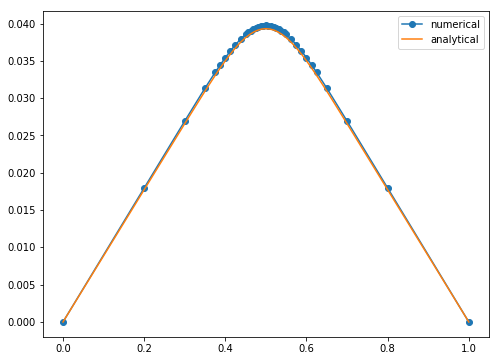

In [15]:
U = np.zeros(M+1)
U[0] = 0
U[M] = 0
U[1:M] = u_int
plt.figure(figsize=(8,6))
plt.plot(x,U,'-o',label='numerical')
plt.plot(xx,uex(xx,rhs),'-',label='analytical')
plt.legend()
plt.show()